# Statevector Separability Algorithm
## Introduction
In this project, an algorithm for determining the separability of an arbitrary input quantum state, in the form of a vector of length 2^N (for an N-qubit state), is implemented. Current attempts include using a deterministic algorithm on checking the eigenvalues of the H matrix (referring to the Cavendish Lecture 5 Notes on Entanglement[1]), and a probabilistic algorithm using binary classification in machine learning with some feature engineering. 

The first method is deemed to work very well for some simple separable states with not many qubits, but would fail terribly either in accuracy or runtime due to the huge rounding error accumulated. To improve the algorithm's performance for more qubits, the second method is researched and developed.

Since the second method is expected to be overall better, this walkthrough will mainly focus on binary classification machine learning algorithms, but the first method is also included near the end for reference and sharing some thoughts when trying to solve this problem. 

## Random State Generation
To begin applying the binary classifiers, first we need to randomly generate some arbitrary statevectors as length-2^N arrays, whilst labeling some of them to be separable and some of them not.

We first import the necessary Python modules for the following procedures.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
import random
import time


Then, we need to implement the subroutine for generating an arbitrary state `generate_state(num_qubits, separable=False, is_complex=True)`. 

In [14]:
def generate_state(num_qubits, separable=False, is_complex=False):    # default to generate an inseparable, real state
    if is_complex:
        state = np.zeros(2 ** num_qubits, dtype=complex)    # generates a complex state
    else:
        state = np.zeros(2 ** num_qubits)    # generates a real state
        
    # for simplicity purposes, states generated are not necessarily normalized. Ideally this shouldn't affect the classification.
    if separable:
        # randomly generates a state that can be separated into two arbitrary states
        k = random.choice(range(1, num_qubits))    # the number of qubits in one factor state
        state1 = generate_state(k, is_complex=is_complex)
        state2 = generate_state(num_qubits - k, is_complex=is_complex)
        for i in range(state1.shape[0]):    # multiply two factor states together
            for j in range(state2.shape[0]):
                amp = state1[i] * state2[j]
                state[i * state2.shape[0] + j] = amp
        
    else:
        # randomly generates an arbitrary state
        for k in range(state.shape[0]):
            if is_complex:
                amp = complex(random.uniform(-1, 1), random.uniform(-1, 1))
            else:
                amp = random.uniform(0, 1)
            state[k] = amp
    return state

We can try generating some separable/inseparable random states and check that they are of the correct lengths.

In [15]:
a = generate_state(2)
b = generate_state(3, separable=True)
print(a, a.shape[0])
print(b, b.shape[0])


[0.62615657 0.83569066 0.74472112 0.00631943] 4
[0.27456151 0.10318242 0.06718978 0.27796544 0.38514796 0.1447417
 0.09425213 0.38992291] 8


Now with the basic generation subroutine at hand, we can actually start constructing the training and testing dataset (labeled), using the function `generate_dataset(num_samples, num_qubits, sep_prop=0.5, is_complex=True)`. 

In [17]:
def generate_dataset(num_samples, num_qubits, sep_prop=0.5, is_complex=False):
    # sep_prop, the rough proportion of separable sample states in the dataset, is between 0.0 and 1.0.
    # default to generate a dataset of roughly equal number of separable and inseparable states, all real
    if is_complex:
        samples = np.zeros((num_samples, 2 ** num_qubits), dtype=complex)
    else:
        samples = np.zeros((num_samples, 2 ** num_qubits))
    labels = np.zeros(num_samples)    # in which 1 represents full separability and 0 otherwise
    for i in range(num_samples):
        separable = random.random() < sep_prop    # whether or not this particular random state is separable
        state = generate_state(num_qubits, separable=separable, is_complex=is_complex)
        samples[i] = state
        labels[i] = separable
          
    return samples, labels

Then we may try generating some sample dataset and make sure we get the correct dimensions and proportions of separable sample states.

In [19]:
c_s, c_l = generate_dataset(100, 3, sep_prop=0.6)
d_s, d_l = generate_dataset(300, 4, sep_prop=0.2)
print(c_s.shape, c_l.shape, "number of separable samples = ", c_l.sum(), "proportion of separable states = ", c_l.sum() / c_l.shape)
print(d_s.shape, d_l.shape, "number of separable samples = ", d_l.sum(), "proportion of separable states = ", d_l.sum() / d_l.shape)

(100, 8) (100,) number of separable samples =  55.0 proportion of separable states =  [0.55]
(300, 16) (300,) number of separable samples =  74.0 proportion of separable states =  [0.24666667]


## Naive Bayes Classifier
We now have a try with randomly generated dataset with the Naive Bayes classification algorithm. The Naive Bayes algorithm is a very simple classification algorithm assuming absolute independence between individual features. Namely,

$$
\begin{align}
P(y|x_1, x_2, ..., x_n) &= \frac{P(y)P(x_1, x_2, ..., x_n|y)}{P(x_1, x_2, ..., x_n)}
\\
P(x_1, x_2, ..., x_n|y) &= \prod_{i=1}^n P(x_i|y)
\\
P(x_1, x_2, ..., x_n) &= C
\end{align}
$$

where $(x_1, x_2, ..., x_n)$ is a feature vector and $y$ is the classification label for that vector. Line 1 expresses the ordinary Bayes' theorem, Line 2 shows what we mean by _"absolute independence between individual features"_, and Line 3 assumes equal _a priori_ likelihood of every feature vector. Upon this, we would have

$$
\begin{align}
P(y|x_1, x_2, ..., x_n) &\propto \prod_{i=1}^n P(x_i|y)P(y)
\\
\hat{y} &= \arg\max_y \prod_{i=1}^n P(x_i|y)P(y)
\end{align}
$$

For the process below, we assume a likelihood $P(x_i|y)$ that follows a Gaussian distribution, and $P(y)$ is just the relative frequency of $y$ in the training dataset. We use the `GaussianNB()` classifier from `sklearn`.

In [34]:
x_train, y_train = generate_dataset(30000, 6, sep_prop = 0.48)
x_test, y_test = generate_dataset(10000, 6, sep_prop = 0.63)    # complex dataset is not supported by GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)
n_corr = (y_pred == y_test).sum()
print("Out of {} test samples, {} are correctly classified, giving an accuracy of {}.".format(x_test.shape[0], n_corr, n_corr / x_test.shape[0]))

Out of 10000 test samples, 9289 are correctly classified, giving an accuracy of 0.9289.


Surprisingly, the accuracy using such a simple classification algorithm is decent! It seems that the accuracy is even too high, which involves the problem of __how to properly assess the accuracy__ and some other tests that might be useful, and let's worry about this later. We now try plot a graph showing the relationship between the _accuracy_ and the _ratio of training data size to testing data size_ and see if the performance is correlated to the amount of training, trying with different proportions of separable states in the dataset.

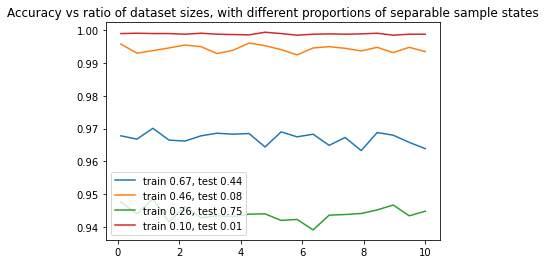

In [49]:
TEST_DATASET_SIZE = 10000
n_qubits = 8

fig, ax = plt.subplots()
for _ in range(4):
    train_sep_prop = random.random()
    test_sep_prop = random.random()    # randomly chooses the proportion of separable states in both training and testing datasets
    size_ratios = np.linspace(0.1, 10, 20)
    train_dataset_sizes = (TEST_DATASET_SIZE * size_ratios).astype(int)
    accuracies = np.zeros(train_dataset_sizes.shape)
    gnb = GaussianNB()
    for i in range(accuracies.shape[0]):   # for every size of the training dataset
        x_train, y_train = generate_dataset(train_dataset_sizes[i], n_qubits, sep_prop=train_sep_prop)
        x_test, y_test = generate_dataset(TEST_DATASET_SIZE, n_qubits, sep_prop=test_sep_prop)
        y_pred = gnb.fit(x_train, y_train).predict(x_test)    # the predicted separability according to the trained model, 
        n_corr = (y_pred == y_test).sum()    # equals 1 for each correct identification, sum up to get total number of correct results
        accuracies[i] = n_corr / x_test.shape[0]

    ax.plot(size_ratios, accuracies, label='train {:.2f}, test {:.2f}'.format(train_sep_prop, test_sep_prop))
ax.legend()
plt.title('Accuracy vs ratio of dataset sizes, with different proportions of separable sample states')

plt.show()
    

As can be seen from the graph, though all being pretty high above 94%, the accuracy is the highest for those testing datasets containing very low proportion of separable states. It is further enhanced if separable sample states are also scarce in the training dataset, as can be seen for the red line with an accuracy of almost 1.00. So it seems after training, no matter what the training dataset is like, the classifier is more inclined to classify a given state as inseparable rather than separable. This shows that the classifier has probably somehow recognized that separable states are rarer than inseparable ones if randomly generated. In contrast, the size of the training dataset relative to the testing dataset does not greatly influence the accuracy, implying that the amount of training is enough to overcome overfitting.

Note that the number of qubits here is still below 10, implying a feature vector of size less than 1,000. More qubits can be used to test if the algorithm would work for larger feature vectors (it probably wouldn't), which could cause a huge increase in runtime. Therefore, some feature engineering would be needed if we want to test for states with more qubits. But for now, if this method of evaluating accuracy is acceptable, a simple classification algorithm like Naive Bayes can already identify separability pretty well!

Next, we might want to first try several different algorithms and see if the accuracy is still promising. Then we will pick out a couple of best-performing models and do some in-depth analysis (e.g. runtime vs number of qubits, effect of different ways of reducing feature size on accuracy, and different ways of assessing the accuracy) on them. Finally, we will conclude with what seems to be the best-performing algorithm with ideas of how to preprocess features, and test it using a mix of (possibly complex) randomly generated and manually given separable/inseparable sample states.